In [1]:
from hsflfm.processing import Aligner, StrikeProcessor
from hsflfm.util import MetadataManager, load_dictionary, save_dictionary

import os
from tqdm import tqdm
import numpy as np

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
save_folder = "temporary_result_storage_7"
assert os.path.exists(save_folder)

saved_results_filename = save_folder + "/processed.json"
if not os.path.exists(saved_results_filename):
    processed_vids = {}
else:
    processed_vids = load_dictionary(saved_results_filename)

In [5]:
specimen_numbers = MetadataManager.all_specimen_numbers()

In [6]:
processed_vids

{}

In [8]:
for i, num in enumerate(specimen_numbers):    
    print(num, f"specimen {i} of {len(specimen_numbers)}")

    try:

        data_manager = MetadataManager(num)
        aligner = Aligner(num, alignment_settings={"enforce_stiff_transform": False,
                                                   "enforce_self_consistency": True})
        strike_numbers = np.sort(data_manager.strike_numbers)
        f = save_folder + f"/{num}"

        if not os.path.exists(f):
            os.mkdir(f)

        if num not in processed_vids:
            processed_vids[num] = []

    except Exception as e:
       print(f"failed on specimen {num}, {e}")

    start_strike = None
    bad_strikes = []

    for strike_num in tqdm(strike_numbers):
        #if strike_num in processed_vids[num]:
        #    print(f"skipping {num} strike {strike_num}")
        #    continue

        

        if strike_num == 2 and num == "20240506_OB_3":
            start_strike = 1
            continue

        #try:
        if True:
            result_info = aligner.prepare_strike_results(
                strike_num, start_strike=start_strike
            )

            # we should check how many points tracked correctly
            # if the number is too low, this strike may not be used for alignment
            # of the next strike
            # this is not a perfect solution but it should be okay for now (2024/11/18)
            based_strike = result_info["aligned_from_strike_number"]
            total_points = len(aligner.stored_point_numbers[1])
            prev_points = len(aligner.stored_point_numbers[based_strike])
            cur_points = len(aligner.stored_point_numbers[strike_num])

            is_good_strike = True

            acceptable_loss = 5
            if len(result_info["removed_points"]) > acceptable_loss:
                if based_strike == 1:
                    bad_strikes.append(strike_num)
                    is_good_strike = False
                else:
                    # try again with a different point
                    # we want to go back to the most recent strike that wasn't deemed too low
                    start_strike_try2 = based_strike - 1
                    while start_strike_try2 in bad_strikes:
                        start_strike_try2 = start_strike_try2 - 1
                    result_info_try2 = aligner.prepare_strike_results(
                        strike_num, start_strike=start_strike_try2
                    )
                    cur_points_try2 = len(aligner.stored_point_numbers[strike_num])

                    # this is not ideal... but go back to other version if this was worse
                    if len(result_info_try2["removed_points"]) > len(result_info["removed_points"]):#cur_points_try2 < cur_points:
                        result_info_try2 = aligner.prepare_strike_results(
                            strike_num, start_strike=start_strike
                        )

                    result_info = result_info_try2

                    # if the total points is still really low,
                    # we should not use this as a start point for the next strike ?
                    if len(result_info_try2["removed_points"]) > acceptable_loss:
                        bad_strikes.append(strike_num)
                        is_good_strike = False

            if is_good_strike:
                start_strike = strike_num
            else:
                start_strike = based_strike







            # processor = StrikeProcessor(result_info)
            # processor.get_flow_vectors()
            # processor.run_regression()
            # processor.get_relative_displacements()

            # result_info = processor.condense_info()
            save_name = f + f"/strike_{strike_num}_results.json"
            save_dictionary(result_info, save_name)

            assert os.path.exists(save_name)
            processed_vids[num].append(int(strike_num))

            #save_dictionary(processed_vids, saved_results_filename)

        #except Exception as e:
        #  print(f"""failed on specimen {num} strike {strike_num}, {e}""")

        # break

    # break

20220422_OB_1 specimen 0 of 30
using manually specified pre-alignment


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


20220427_OB_1 specimen 1 of 30


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


20220427_OB_2 specimen 2 of 30


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


20220427_OB_3 specimen 3 of 30


100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


20220427_OB_4 specimen 4 of 30


100%|██████████| 9/9 [00:04<00:00,  2.12it/s]


20220427_OB_5 specimen 5 of 30


 33%|███▎      | 7/21 [00:05<00:10,  1.28it/s]


KeyboardInterrupt: 

In [7]:
aligner.rough_interstrike_alignment

{np.int64(1): (0, 0),
 np.int64(2): (0, 0),
 np.int64(3): (0, 0),
 np.int64(4): (0, 0),
 np.int64(5): (0, 0),
 np.int64(6): (0, 0),
 np.int64(7): (0, 0),
 np.int64(8): (0, 0)}

In [ ]:
mm = MetadataManager(num) 
image = mm.dark_calibration_images[2] 
image2 = mm.get_start_images(strike_number=1)[2]

from matplotlib import pyplot as plt
#plt.imshow(image) 
plt.imshow(image2 - image)
plt.colorbar()

In [ ]:
def get_filename(specimen, strike_num):
    f = save_folder + f'/{specimen}/strike_{strike_num}_results.json'
    #f = "temporary_result_storage_5" + f'/{specimen}/strike_{strike_num}_results.json'
    assert os.path.exists(f)
    return f 

specimen = "20240503_OB_3"
strike = 5
res1 = load_dictionary(get_filename(specimen, 1))
res2 = load_dictionary(get_filename(specimen,strike))

mm = MetadataManager(specimen)
cam = 0
img1 = mm.get_start_images(strike_number=1)[cam]
img2 = mm.get_start_images(strike_number=strike)[cam]

from matplotlib import pyplot as plt
plt.imshow(img1, cmap='gray')
mp = np.asarray(res1["match_points"][cam])
plt.scatter(mp[:, 1], mp[:, 0], s=5)

#plt.figure()
#plt.imshow(img2, cmap='gray')
mp = np.asarray(res2["match_points"][cam])
plt.scatter(mp[:, 1], mp[:, 0], s=5)

In [ ]:
# to a pixel in a camera
def world_frame_to_pixel(system, point, camera=2):
    ref_camera = system.reference_camera
    # use the magnification at that z-plane to switch x, y value back to pixels
    mag0 = system.get_magnification_at_plane(
        camera_number=ref_camera, plane_mm=point[2], dim=0
    )
    mag1 = system.get_magnification_at_plane(
        camera_number=ref_camera, plane_mm=point[2], dim=1
    )

    pixel_size_m = system.calib_manager.pixel_size
    pixels = (
        point[0] * mag0 / (pixel_size_m * 1e3),
        point[1] * mag1 / (pixel_size_m * 1e3),
    )

    # shift to the reference plane 
    #v0_ref, v1_ref = system.get_shift_slopes(system.reference_camera, [pixels[0]], [pixels[1]])
    #pixels = (pixels[0] + point[2] * v0_ref, pixels[1] + point[2] * v1_ref)

    # then shift to the other camera if it's not the reference camera
    s0, s1 = system.get_pixel_shifts(camera, [pixels[0]], [pixels[1]])
    pixels = (pixels[0] - s0, pixels[1] - s1)

    # then use height and calibration model to find the pixel
    v0, v1 = system.get_shift_slopes(camera, [pixels[0]], [pixels[1]])
    pixels = (pixels[0] - point[2] * v0, pixels[1] - point[2] * v1)

    return pixels

In [ ]:

from hsflfm.calibration import FLF_System
from hsflfm.processing import get_point_locations #, world_frame_to_pixel
system = FLF_System(mm.calibration_filename)
camera_locations = get_point_locations(system, res1["match_points"], return_average=False)
camera_locations_ = camera_locations.sel({"camera_combo": "0, 2"}).data
camera_locations_[:, 2] = np.nanmean(camera_locations_[:, 2:], axis=-1)
camera_locations = camera_locations_[:, :3]

camera_locations = get_point_locations(system, res1["match_points"])#, return_average=False)


new_match_points = {}
for key in range(3):
    new_mp = [] 
    for p in camera_locations:
        pixel = world_frame_to_pixel(system, p, camera=cam)
        new_mp.append(pixel)
    new_mp = np.asarray(new_mp).squeeze()
    new_match_points[key] = new_mp



plt.imshow(img1, cmap='gray')
mp = np.asarray(res1["match_points"][cam])
plt.scatter(mp[:, 1], mp[:, 0], s=3)
plt.scatter(new_mp[:, 1], new_mp[:, 0], s=3, color='red')

plt.imshow(mm.dark_calibration_images[cam], cmap='gray', alpha=0.4)

plt.figure()
plt.imshow(mm.dark_calibration_images[cam] - img1)

In [ ]:
new_match_points[2].shape

In [ ]:
camera_locations2 = get_point_locations(system, new_match_points, return_average=True)
new_match_points2 = {}
for key in range(3):
    new_mp2 = [] 
    for p in camera_locations:
        pixel = world_frame_to_pixel(system, p, camera=cam)
        new_mp2.append(pixel)
    new_mp2 = np.asarray(new_mp2)
    new_match_points2[key] = new_mp2

plt.imshow(img1, cmap='gray')
plt.scatter(new_mp2[:, 1], new_mp2[:, 0], s=3)
plt.scatter(new_mp[:, 1], new_mp[:, 0], s=3, color='red')

In [ ]:
res1["strike1_match_points"][0][0]

In [ ]:
res1["match_points"][0][0]

In [7]:
from hsflfm.util import MetadataManager, load_dictionary
from matplotlib import pyplot as plt
import numpy as np

[]

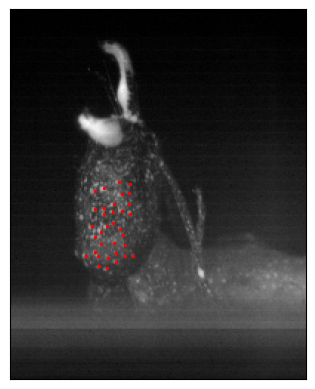

In [16]:
specimen_name = "20240502_OB_1"
mm = MetadataManager(specimen_name)
cam_num = 2
image = mm.get_start_images(strike_number=1)[cam_num]
match_points = np.asarray(load_dictionary(mm.match_points_filename)[cam_num])

plt.imshow(image, cmap='gray')
plt.scatter(match_points[:, 1], match_points[:, 0],
            color='red', s=2)
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])

In [12]:
match_points.shape

(57, 5)